In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

In [2]:
from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

In [3]:
def apply_best_on_packets(packets, max_fitness, flow_id):

    index = max_fitness[1][2]
    #print(index)
    if index == 0:
        return packets
    
    params = max_fitness[1][1][index-1] # best technique
    #print(f'saved:{params}')
    
    if index == 1:
        #print('packet_size_nor')
        #print(f'size: {prepare_size_stats(packets, flow_id)}')
        
        return adjust_packet_size(packets, flow_id, params['direction'], 'normal', params['scaling_factor'], params['focus_point'])
        
                
    elif index == 2:
        #print('packet_size_uni')
        #print(f'size: {prepare_size_stats(packets, flow_id)}')
        return adjust_packet_size(packets, flow_id, params['direction'], 'uniform', params['scaling_factor'], params['focus_point'])
                
    elif index == 3:
        #print('packet_time_norm')
        #print(f'time: {prepare_timing_stats(packets, flow_id)}')
        return apply_time_perturbation_with_focus(packets, flow_id, 'normal', params['focus_point'], params['scaling_factor'])
                
    elif index == 4:
        #print('packet_time_uni')
        #print(f'time: {prepare_timing_stats(packets, flow_id)}')
        return apply_time_perturbation_with_focus(packets, flow_id, 'uniform', params['focus_point'], params['scaling_factor'])
        
    return packets

In [4]:
import pygad
import copy

class FlowOptimizer:
    def __init__(self, packets, model_name, flow_id, max_fitness, target):
        self.packets = packets
        self.model_name = model_name
        self.flow_id = flow_id
        self.ga_instance = None
        self.max_fitness = max_fitness
        self.target = target
        
    def apply_best_solution(self):
        best_solution, best_solution_fitness, _ = self.ga_instance.best_solution()
        best_operations = self.decode_operations(best_solution)
        # Stosujemy najlepsze operacje do pakietów
        self.best_modified_packets = self.apply_operations_to_packets(best_operations, self.packets, self.flow_id)
        return self.best_modified_packets, best_solution_fitness

    def on_generation(self, ga_instance):
        pass
            
    def on_fitness(self, ga_instance):
        ga_instance.plot_fitness()

    def fitness_function(self, ga_instance, solution, solution_idx):
        
        fitnesses = []
        target_fitnesses = []
        
        operations = self.decode_operations(solution)
        
        modified_packets = self.packets # always check nop
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[0], op_type = 'size_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        #print(sizing_stats)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[1], op_type = 'size_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[2], op_type = 'time_norm')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))
        
        modified_packets = self.apply_operations_to_packets(operations[3], op_type = 'time_uni')
        sizing_stats = prepare_size_stats(modified_packets, self.flow_id)
        timing_stats = prepare_timing_stats(modified_packets, self.flow_id)
        fitnesses.append(1.0 - predict_single_flow(self.model_name, sizing_stats, timing_stats))
        target_fitnesses.append(1.0 - predict_single_flow_target(self.model_name, sizing_stats, timing_stats))

        if self.target:
            max_fitness_value = max(target_fitnesses)
            max_fitness_index = target_fitnesses.index(max_fitness_value) 

        else:
            max_fitness_value = max(fitnesses) 
            max_fitness_index = fitnesses.index(max_fitness_value) 

        max_fitness_target = target_fitnesses[max_fitness_index]

        #print(self.max_fitness)
        if max_fitness_value > self.max_fitness[0][0]:
            #print(f'CONDITION max: {max_fitness_value}, prev: {self.max_fitness[0]}')
            self.max_fitness = [[max_fitness_value, max_fitness_target], self.decode_operations(solution), max_fitness_index]
            #print(f'self:{self.max_fitness[0]}')
        
        #print(max_fitness_value)
        #print(f'solution:{solution}')
        #print(f'finresses: {fitnesses}, solution:{self.decode_operations(solution)}')
        
        return max_fitness_value

    def optimize_for_flow(self):
        
        #with open(f"progress_for_flow_{self.flow_id}.txt", "w") as file:
        #    file.write("")  # Tylko czyszczenie zawartości pliku
            
        ga_instance = pygad.GA(num_generations=2,
                               num_parents_mating=1,
                               fitness_func=self.fitness_function,
                               sol_per_pop=3,                          
                               mutation_probability=0.7,
                               suppress_warnings= True,
                               on_generation=self.on_generation,
                               num_genes=6, # operations number
                               gene_space = [{'low': 1.1, 'high': 5.0},  # size normal
                                             {'low': 0.25, 'high': 5.0}, # packet size uniform
                                             {'low': 1.1, 'high': 3.0}, # time normal
                                             {'low': 0.4, 'high': 2.4}, # time uniform
                                            [0,1,2],  # direction
                                            [0,1,2]]) # focus point 

        
        ga_instance.run()
        return ga_instance, self.max_fitness

    def decode_operations(self, genotype):
        operations = []
        

        focus_point_map = {0: "start", 1: "middle", 2: "end"}
        focus_point = None
        focus_point_index = genotype[5] 
        focus_point = focus_point_map.get(focus_point_index, None)  

        size_norm = {
            'scaling_factor': genotype[0],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        size_uni = {
            'scaling_factor': genotype[1],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        time_norm = {
            'scaling_factor': genotype[2],
            'direction': genotype[4],
            'focus_point': focus_point
        }
        
        
        time_uni = {
            'scaling_factor': genotype[3],
            'direction': genotype[4],
            'focus_point': focus_point
        }  
            
            
        
        operations = [size_norm, size_uni, time_norm, time_uni]
        return operations 
        


    def apply_operations_to_packets(self, operation, op_type):

        #packets = copy.deepcopy(self.packets) # deep copy for testing
        #print(f'size: {prepare_size_stats(self.packets, self.flow_id)}')
        #print(f'time: {prepare_timing_stats(self.packets, self.flow_id)}')


        scaling_factor = operation['scaling_factor']
        direction = operation.get('direction')
        focus_point = operation.get('focus_point')
        

        if op_type == 'size_norm':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'normal', scaling_factor, focus_point)
            
            
        elif op_type == 'size_uni':
            packets = adjust_packet_size_deepcopy(self.packets, self.flow_id, direction, 'uniform', scaling_factor, focus_point)
            
        elif op_type == 'time_norm':
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'normal', focus_point, scaling_factor)
            
        elif op_type == 'time_uni':
            #print(f'przed: {prepare_timing_stats(self.packets, self.flow_id)}')
            packets = apply_time_perturbation_with_focus_deepcopy(self.packets, self.flow_id, 'uniform', focus_point, scaling_factor)
            #print(f'po: {prepare_timing_stats(packets, self.flow_id)}')
            
        #print(packets)
        return packets
    

            
        

    #print(optimizer.best_solution())
    


In [5]:
import os
import pickle

def save_object_pickle(obj, filepath):
    """
    Saves an object to a specified filepath using pickle.
    
    Parameters:
    - obj: The object to save.
    - filepath: The path to the file where the object should be saved.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    with open(filepath, 'wb') as pickle_file:  # Note 'wb' for writing in binary mode
        pickle.dump(obj, pickle_file)

def load_object_pickle(filepath):
    """
    Loads an object from a specified filepath using pickle.
    
    Parameters:
    - filepath: The path to the file from which to load the object.
    
    Returns:
    - The loaded object.
    """
    with open(filepath, 'rb') as pickle_file:  # Note 'rb' for reading in binary mode
        obj = pickle.load(pickle_file)
    return obj


In [3]:
captures = [
    "botnet-capture-20110811-neris",
    "botnet-capture-20110812-rbot",
    "botnet-capture-20110815-fast-flux-2",
    "botnet-capture-20110815-fast-flux",
    "botnet-capture-20110815-rbot-dos",
    "botnet-capture-20110816-donbot",
    "botnet-capture-20110816-qvod",
    "botnet-capture-20110816-sogou",
    "botnet-capture-20110817-bot",
    "botnet-capture-20110818-bot-2",
    "botnet-capture-20110819-bot"
]


In [7]:
def save_truncated(file_name, truncated_packets_list):
    with open(file_name, 'wb') as f:
        pickle.dump(truncated_packets_list, f)
        print(f'Saved: {file_name}')


In [ ]:
import copy
import os
import pickle

def process_flow_id(flow_id, packets, model, target=False):
    print(f"Starting work on flow_id: {flow_id}")
    truncated_packets = copy.deepcopy(packets)  
    inter = []
    max_fitness = [0, [[0, 0], 0, 0], 0]
    previous_max = 0
    
    for i in range(5):
        optimizer = FlowOptimizer(truncated_packets, model, flow_id, max_fitness[1], target)
        max_fitness = optimizer.optimize_for_flow()
        inter.append(max_fitness[1][0][0])
        
        if max_fitness[1][0][0] > previous_max:
            truncated_packets = apply_best_on_packets(truncated_packets, max_fitness, flow_id)
            previous_max = max_fitness[1][0][0]

    return flow_id, inter, truncated_packets

def main():

    updated_truncated_packets_list = []

    # FITNESS FUNCTION RF
    for capture in captures:
        print(f'Working on capture: {capture}')

        modified_pcap_path = f"../data/interim/{capture}_perturbed.pcapng"
        pcap_file_path = f'../data/raw/filtered/{capture}.pcap'
        save_object_path = f"../data/metadata/ga_rf_fitness_{capture}_perturbed.pkl"
        model_name = f'{capture}'

        truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
        print(f"Total packets loaded: {len(truncated_packets)}")
        truncated_packets = assign_flow_ids_to_packets(truncated_packets)

        flow_ids = set(packet.flow_id for packet in truncated_packets)
        extern = []
        updated_truncated_packets = truncated_packets  # Start with the original packet list

        for fid in flow_ids:
            flow_id, inter, updated_truncated_packets = process_flow_id(fid, updated_truncated_packets, model_name, target=False)
            extern.append(inter)
            print(f"Completed processing flow_id {flow_id}, final results: {inter}")

        modify_and_write_packets_one_by_one(pcap_file_path, modified_pcap_path, updated_truncated_packets)
        updated_truncated_packets_list.append(updated_truncated_packets)
        
        with open(save_object_path, 'wb') as f:
            pickle.dump(extern, f)

        print(f"Finished and saved: {capture}")

    save_truncated("../data/metadata/truncated_list_fitness", updated_truncated_packets_list)
    updated_truncated_packets_list = [] # cleaning the list for another case
    
    # FITNESS FUNCTION TARGET MODEL
    for capture in captures:
        print(f'(Target) Working on capture: {capture}')

        modified_pcap_path = f"../data/interim/{capture}_perturbed_target.pcapng"
        pcap_file_path = f'../data/raw/filtered/{capture}.pcap'
        save_object_path = f"../data/metadata/ga_rf_fitness_{capture}_perturbed_target.pkl"
        model_name = f'{capture}'

        truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
        print(f"Total packets loaded: {len(truncated_packets)}")
        truncated_packets = assign_flow_ids_to_packets(truncated_packets)

        flow_ids = set(packet.flow_id for packet in truncated_packets)
        extern = []
        updated_truncated_packets = truncated_packets  # Start with the original packet list

        for fid in flow_ids:
            flow_id, inter, updated_truncated_packets = process_flow_id(fid, updated_truncated_packets, model_name, target=True)
            extern.append(inter)
            print(f"Completed processing flow_id {flow_id}, final results: {inter}")

        modify_and_write_packets_one_by_one(pcap_file_path, modified_pcap_path, updated_truncated_packets)
        updated_truncated_packets_list.append(updated_truncated_packets)
        
        with open(save_object_path, 'wb') as f:
            pickle.dump(extern, f)

        print(f"Finished and saved: {capture}")

    save_truncated("../data/metadata/truncated_list_target" ,updated_truncated_packets_list)

if __name__ == "__main__":
    main()


Working on capture: botnet-capture-20110811-neris
Total packets loaded: 4955
hash groups: 593
Starting work on flow_id: 1
Completed processing flow_id 1, final results: [0.148018868600873, 0.2080194822274305, 0.20926018030148952, 0.21335378889877465, 0.21335378889877465]
Starting work on flow_id: 2
Completed processing flow_id 2, final results: [0.08528348087665605, 0.10878278692751864, 0.1115551000400613, 0.1115551000400613, 0.1115551000400613]
Starting work on flow_id: 3
Completed processing flow_id 3, final results: [0.040148350018459955, 0.08665082384874467, 0.11639819239382643, 0.11674891791631581, 0.11674891791631581]
Starting work on flow_id: 4
Completed processing flow_id 4, final results: [0.058190477427759624, 0.06610414945111631, 0.08459979866945222, 0.1007700871901801, 0.11063632070890339]
Starting work on flow_id: 5
Completed processing flow_id 5, final results: [0.10770731907846232, 0.11455509140797804, 0.12771687567933754, 0.1310350486382229, 0.14102797900673014]
Startin

In [ ]:
truncated_packets

In [ ]:
# TODO: evaluation processing pipeline with all commands

In [7]:
captures

['botnet-capture-20110811-neris',
 'botnet-capture-20110812-rbot',
 'botnet-capture-20110815-fast-flux-2',
 'botnet-capture-20110815-fast-flux',
 'botnet-capture-20110815-rbot-dos',
 'botnet-capture-20110816-donbot',
 'botnet-capture-20110816-qvod',
 'botnet-capture-20110816-sogou',
 'botnet-capture-20110817-bot',
 'botnet-capture-20110818-bot-2',
 'botnet-capture-20110819-bot']

In [8]:
# processing each capture (perturbed and raw) with cicflowmeter tool
env_name = 'cicflowmeter_env'

for capture in captures:
    raw_command = f'cicflowmeter -f ../data/raw/filtered/{capture}.pcap -c ../data/processed/{capture}_orig_flows.csv'
    perturbed_command = f'cicflowmeter -f ../data/interim/{capture}_perturbed.pcapng -c ../data/processed/{capture}_perturbed_flows.csv'
    perturbed_target_command = f'cicflowmeter -f ../data/interim/{capture}_perturbed_target.pcapng -c ../data/processed/{capture}_perturbed_target_flows.csv'

    print(f'Running: {raw_command}')
    !conda run -n {env_name} {raw_command}

    print(f'Running: {perturbed_command}')
    !conda run -n {env_name} {perturbed_command}

    print(f'Running: {perturbed_target_command}')
    !conda run -n {env_name} {perturbed_target_command}

print("Finished running the commands")


Running: cicflowmeter -f ../data/raw/filtered/botnet-capture-20110811-neris.pcap -c ../data/processed/botnet-capture-20110811-neris_orig_flows.csv
reading from file ../data/raw/filtered/botnet-capture-20110811-neris.pcap, link-type EN10MB (Ethernet)

Running: cicflowmeter -f ../data/interim/botnet-capture-20110811-neris_perturbed.pcapng -c ../data/processed/botnet-capture-20110811-neris_perturbed_flows.csv
reading from file ../data/interim/botnet-capture-20110811-neris_perturbed.pcapng, link-type EN10MB (Ethernet)

Running: cicflowmeter -f ../data/interim/botnet-capture-20110811-neris_perturbed_target.pcapng -c ../data/processed/botnet-capture-20110811-neris_perturbed_target_flows.csv
reading from file ../data/interim/botnet-capture-20110811-neris_perturbed_target.pcapng, link-type EN10MB (Ethernet)

Running: cicflowmeter -f ../data/raw/filtered/botnet-capture-20110812-rbot.pcap -c ../data/processed/botnet-capture-20110812-rbot_orig_flows.csv
reading from file ../data/raw/filtered/botn

In [9]:
import pickle

def load_truncated_packets_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        truncated_packets_list = pickle.load(f)
    return truncated_packets_list

file_path = "updated_truncated_packets_pickle"
loaded_packets_list = load_truncated_packets_from_pickle(file_path)
print(f"Loaded {len(loaded_packets_list)} lists of TruncatedPacket objects.")


Loaded 11 lists of TruncatedPacket objects.


In [11]:
# load packets from perturbed files and make flow IDs assigment

loaded_packets_fitness = []
loaded_packets_target = []

for capture in captures:
    modified_pcap_path_fitness = f"../data/interim/{capture}_perturbed.pcapng"
    modified_pcap_path_target = f"../data/interim/{capture}_perturbed_target.pcapng"

    print(f"loading: {modified_pcap_path_fitness}...")
    loaded_packets_fitness.append(assign_flow_ids_to_packets(create_truncated_packets_from_pcap(modified_pcap_path_fitness)))

    print(f"loading: {modified_pcap_path_target}...")
    loaded_packets_target.append(assign_flow_ids_to_packets(create_truncated_packets_from_pcap(modified_pcap_path_target)))

loading: ../data/interim/botnet-capture-20110811-neris_perturbed.pcapng...
hash groups: 593
loading: ../data/interim/botnet-capture-20110811-neris_perturbed_target.pcapng...
hash groups: 593
loading: ../data/interim/botnet-capture-20110812-rbot_perturbed.pcapng...
hash groups: 449
loading: ../data/interim/botnet-capture-20110812-rbot_perturbed_target.pcapng...
hash groups: 449
loading: ../data/interim/botnet-capture-20110815-fast-flux-2_perturbed.pcapng...
hash groups: 366
loading: ../data/interim/botnet-capture-20110815-fast-flux-2_perturbed_target.pcapng...
hash groups: 366
loading: ../data/interim/botnet-capture-20110815-fast-flux_perturbed.pcapng...
hash groups: 139
loading: ../data/interim/botnet-capture-20110815-fast-flux_perturbed_target.pcapng...
hash groups: 139
loading: ../data/interim/botnet-capture-20110815-rbot-dos_perturbed.pcapng...
hash groups: 85
loading: ../data/interim/botnet-capture-20110815-rbot-dos_perturbed_target.pcapng...
hash groups: 85
loading: ../data/interi

In [43]:
# make statistical calculations

fitness_predictions = []

# fitness
for i in range(0, len(captures)):

    capture = captures[i]

    print(f"Processing fitness capture {capture}")

    if i >= len(fitness_predictions):
        fitness_predictions.append([])

    unique_flow_ids = list({packet.flow_id for packet in loaded_packets_fitness[i]})
    for id in unique_flow_ids:
        
        sizing_stats = prepare_size_stats(loaded_packets_fitness[i], id)
        timing_stats = prepare_timing_stats(loaded_packets_fitness[i], id)
        
        fitness_predictions[i].append(predict_single_flow_target(f"{capture}", sizing_stats, timing_stats))

target_predictions = []

# target
for i in range(0, len(captures)):

    capture = captures[i]

    print(f"Processing target capture {capture}")

    if i >= len(target_predictions):
        target_predictions.append([])
    
    unique_flow_ids = list({packet.flow_id for packet in loaded_packets_target[i]})
    for id in unique_flow_ids:
        
        sizing_stats = prepare_size_stats(loaded_packets_target[i], id)
        timing_stats = prepare_timing_stats(loaded_packets_target[i], id)
        
        target_predictions[i].append(predict_single_flow_target(f"{capture}", sizing_stats, timing_stats))


Processing fitness capture botnet-capture-20110811-neris
Processing fitness capture botnet-capture-20110812-rbot
Processing fitness capture botnet-capture-20110815-fast-flux-2
Processing fitness capture botnet-capture-20110815-fast-flux
Processing fitness capture botnet-capture-20110815-rbot-dos
Processing fitness capture botnet-capture-20110816-donbot
Processing fitness capture botnet-capture-20110816-qvod
Processing fitness capture botnet-capture-20110816-sogou
Processing fitness capture botnet-capture-20110817-bot
Processing fitness capture botnet-capture-20110818-bot-2
Processing fitness capture botnet-capture-20110819-bot
Processing target capture botnet-capture-20110811-neris
Processing target capture botnet-capture-20110812-rbot
Processing target capture botnet-capture-20110815-fast-flux-2
Processing target capture botnet-capture-20110815-fast-flux
Processing target capture botnet-capture-20110815-rbot-dos
Processing target capture botnet-capture-20110816-donbot
Processing targe

In [44]:
# [0, 1] mapping for fitness_predictions
fitness_predictions = [[min(1, max(0, x)) for x in sublist] for sublist in fitness_predictions]

# [0, 1] mapping for target_predictions
target_predictions = [[min(1, max(0, x)) for x in sublist] for sublist in target_predictions]


for i in range(0, len(captures)):

    capture = captures[i]

    print(f"FITNESS {capture} : {np.mean(fitness_predictions[i])}")
    print(f"TARGET {capture} : {np.mean(target_predictions[i])}/n")


FITNESS botnet-capture-20110811-neris : 0.929291724351517
TARGET botnet-capture-20110811-neris : 0.8098946696913665/n
FITNESS botnet-capture-20110812-rbot : 0.9349602529610337
TARGET botnet-capture-20110812-rbot : 0.4233948742427166/n
FITNESS botnet-capture-20110815-fast-flux-2 : 0.8797642711397821
TARGET botnet-capture-20110815-fast-flux-2 : 0.7512004457726406/n
FITNESS botnet-capture-20110815-fast-flux : 0.9053115093675365
TARGET botnet-capture-20110815-fast-flux : 0.7498462243066918/n
FITNESS botnet-capture-20110815-rbot-dos : 0.6168757820288329
TARGET botnet-capture-20110815-rbot-dos : 0.3979899712603029/n
FITNESS botnet-capture-20110816-donbot : 0.9281591589789195
TARGET botnet-capture-20110816-donbot : 0.8879196490455975/n
FITNESS botnet-capture-20110816-qvod : 0.8703235037589522
TARGET botnet-capture-20110816-qvod : 0.7434755824429026/n
FITNESS botnet-capture-20110816-sogou : 0.9404422415482779
TARGET botnet-capture-20110816-sogou : 0.8574394089832252/n
FITNESS botnet-capture-20

In [45]:
fitness_means = [np.mean([x for x in sublist]) for sublist in fitness_predictions]
overall_fitness_mean = np.mean(fitness_means)

target_means = [np.mean([x for x in sublist]) for sublist in target_predictions]
overall_target_mean = np.mean(target_means)

print(f"All FITNESS mean: {overall_fitness_mean}")
print(f"All TARGET mean: {overall_target_mean}")

All FITNESS mean: 0.8800837821774693
All TARGET mean: 0.7215744166993472


In [31]:
# SAME CASE SCENARIO HOWEVER FOR CALCULATED TRUNCATIONS (saved in pickle files) 
# without real pcap processing

def load_truncated_packets_from_pickle(file_path):
        with open(file_path, 'rb') as f:
            truncated_packets_list = pickle.load(f)
        return truncated_packets_list

fitness_file_path = "../data/metadata/truncated_list_fitness"
target_file_path = "../data/metadata/truncated_list_target"
 
loaded_packets_list_target = load_truncated_packets_from_pickle(target_file_path)
print(f"Loaded {len(loaded_packets_list_target)} lists of TruncatedPacket objects for target.")

loaded_packets_list_fitness = load_truncated_packets_from_pickle(fitness_file_path)
print(f"Loaded {len(loaded_packets_list_fitness)} lists of TruncatedPacket objects for fitness.")


Loaded 11 lists of TruncatedPacket objects for target.
Loaded 11 lists of TruncatedPacket objects for fitness.


In [36]:
# make statistical calculations (for pickled truncated packets)

fitness_predictions = []

# fitness
for i in range(0, len(captures)):

    capture = captures[i]

    print(f"Processing fitness capture {capture} (own flow processing)")

    if i >= len(fitness_predictions):
        fitness_predictions.append([])

    unique_flow_ids = list({packet.flow_id for packet in loaded_packets_list_fitness[i]})
    for id in unique_flow_ids:
        
        sizing_stats = prepare_size_stats(loaded_packets_fitness[i], id)
        timing_stats = prepare_timing_stats(loaded_packets_fitness[i], id)
        
        fitness_predictions[i].append(predict_single_flow_target(f"{capture}", sizing_stats, timing_stats))

target_predictions = []

# target
for i in range(0, len(captures)):

    capture = captures[i]

    print(f"Processing target capture {capture} (own flow processing)")

    if i >= len(target_predictions):
        target_predictions.append([])
    
    unique_flow_ids = list({packet.flow_id for packet in loaded_packets_list_target[i]})
    for id in unique_flow_ids:
        
        sizing_stats = prepare_size_stats(loaded_packets_list_target[i], id)
        timing_stats = prepare_timing_stats(loaded_packets_list_target[i], id)
        
        target_predictions[i].append(predict_single_flow_target(f"{capture}", sizing_stats, timing_stats))


Processing fitness capture botnet-capture-20110811-neris
Processing fitness capture botnet-capture-20110812-rbot
Processing fitness capture botnet-capture-20110815-fast-flux-2
Processing fitness capture botnet-capture-20110815-fast-flux
Processing fitness capture botnet-capture-20110815-rbot-dos
Processing fitness capture botnet-capture-20110816-donbot
Processing fitness capture botnet-capture-20110816-qvod
Processing fitness capture botnet-capture-20110816-sogou
Processing fitness capture botnet-capture-20110817-bot
Processing fitness capture botnet-capture-20110818-bot-2
Processing fitness capture botnet-capture-20110819-bot
Processing target capture botnet-capture-20110811-neris (own flow processing)
Processing target capture botnet-capture-20110812-rbot (own flow processing)
Processing target capture botnet-capture-20110815-fast-flux-2 (own flow processing)
Processing target capture botnet-capture-20110815-fast-flux (own flow processing)
Processing target capture botnet-capture-201

In [35]:
# [0, 1] mapping for fitness_predictions
fitness_predictions = [[min(1, max(0, x)) for x in sublist] for sublist in fitness_predictions]

# [0, 1] mapping for target_predictions
target_predictions = [[min(1, max(0, x)) for x in sublist] for sublist in target_predictions]


for i in range(0, len(captures)):

    capture = captures[i]

    print(f"FITNESS (own flow processing) {capture} : {np.mean(fitness_predictions[i])}")
    print(f"TARGET (own flow processing) {capture} : {np.mean(target_predictions[i])}\n")


FITNESS (own flow processing) botnet-capture-20110811-neris : 0.9289352120373229
TARGET (own flow processing) botnet-capture-20110811-neris : 0.8180436165546642

FITNESS (own flow processing) botnet-capture-20110812-rbot : 0.6676298240269759
TARGET (own flow processing) botnet-capture-20110812-rbot : 0.3307168870693952

FITNESS (own flow processing) botnet-capture-20110815-fast-flux-2 : 0.8602328551367113
TARGET (own flow processing) botnet-capture-20110815-fast-flux-2 : 0.7477796030866669

FITNESS (own flow processing) botnet-capture-20110815-fast-flux : 0.7745083979102995
TARGET (own flow processing) botnet-capture-20110815-fast-flux : 0.761448964729789

FITNESS (own flow processing) botnet-capture-20110815-rbot-dos : 0.6097267230071997
TARGET (own flow processing) botnet-capture-20110815-rbot-dos : 0.4015562615748375

FITNESS (own flow processing) botnet-capture-20110816-donbot : 0.8996605604514756
TARGET (own flow processing) botnet-capture-20110816-donbot : 0.8895786877952362

FIT

In [37]:
fitness_means = [np.mean([x for x in sublist]) for sublist in fitness_predictions]
overall_fitness_mean = np.mean(fitness_means)

target_means = [np.mean([x for x in sublist]) for sublist in target_predictions]
overall_target_mean = np.mean(target_means)

print(f"All FITNESS mean: {overall_fitness_mean}")
print(f"All TARGET mean: {overall_target_mean}")

All FITNESS mean: 0.8101958072300008
All TARGET mean: 0.7110696388328234


In [ ]:
# VIZUALIZATIONS:

Testing botnet-capture-20110811-neris_regressor:
Accuracy: 98.68364%
Predicted distribution: 0    0.981325
dtype: float64
Number of samples: 608
Number of malicious (1) predictions: 0    608
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


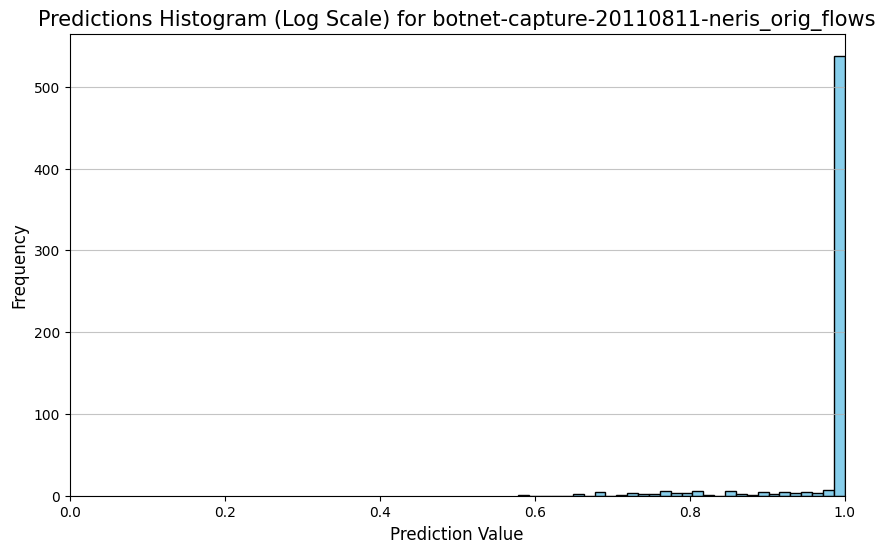

Testing botnet-capture-20110812-rbot_regressor:
Accuracy: 99.87588%
Predicted distribution: 0    0.998564
dtype: float64
Number of samples: 452
Number of malicious (1) predictions: 0    452
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


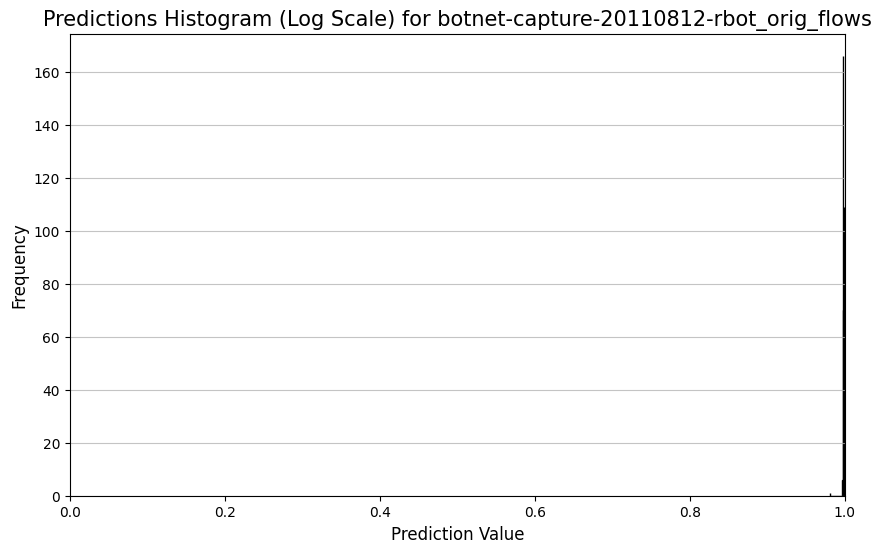

Testing botnet-capture-20110815-fast-flux-2_regressor:
Accuracy: 100.00183%
Predicted distribution: 0    0.999733
dtype: float64
Number of samples: 377
Number of malicious (1) predictions: 0    377
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


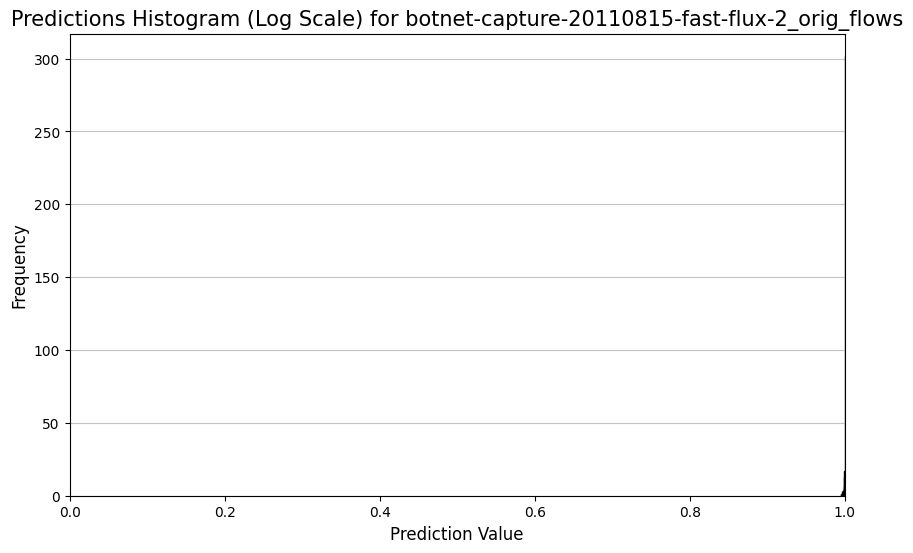

Testing botnet-capture-20110815-fast-flux-2_regressor:
Accuracy: 99.98915%
Predicted distribution: 0    0.999566
dtype: float64
Number of samples: 145
Number of malicious (1) predictions: 0    145
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


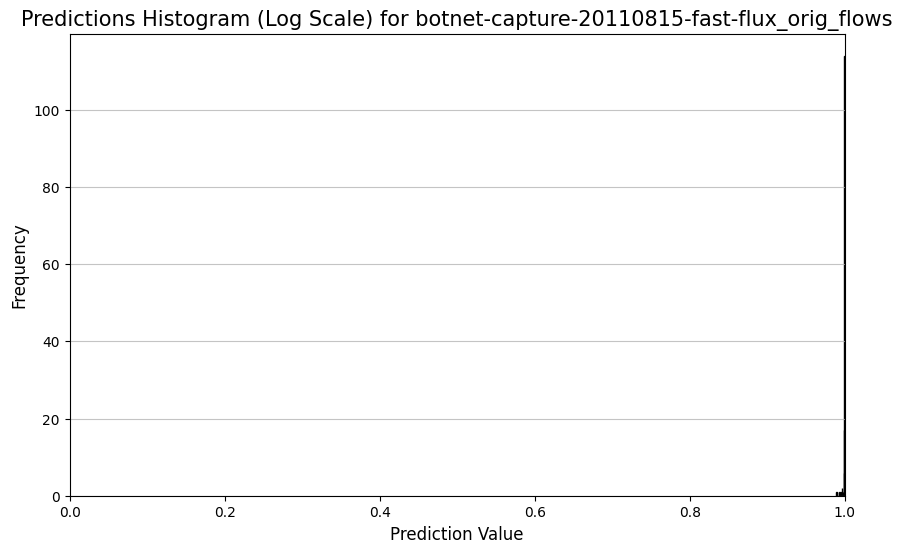

Testing botnet-capture-20110815-fast-flux_regressor:
Accuracy: 99.99511%
Predicted distribution: 0    0.999662
dtype: float64
Number of samples: 145
Number of malicious (1) predictions: 0    145
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


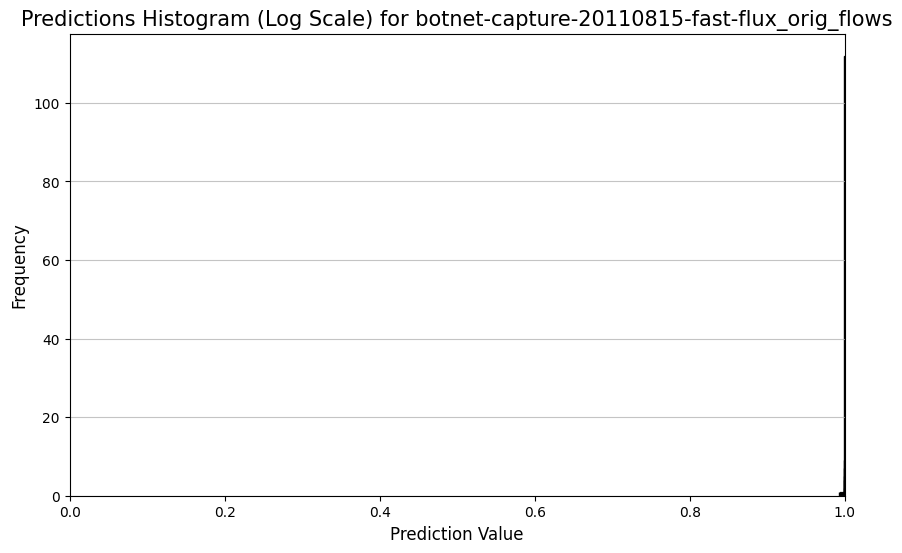

Testing botnet-capture-20110815-rbot-dos_regressor:
Accuracy: 100.06687%
Predicted distribution: 0    0.998952
dtype: float64
Number of samples: 91
Number of malicious (1) predictions: 0    91
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


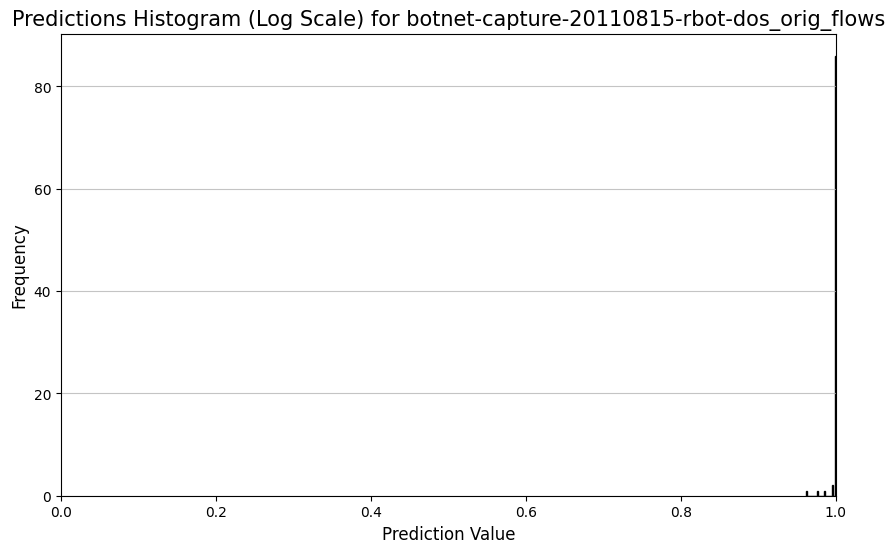

Testing botnet-capture-20110816-donbot_regressor:
Accuracy: 99.99665%
Predicted distribution: 0    0.999866
dtype: float64
Number of samples: 659
Number of malicious (1) predictions: 0    659
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


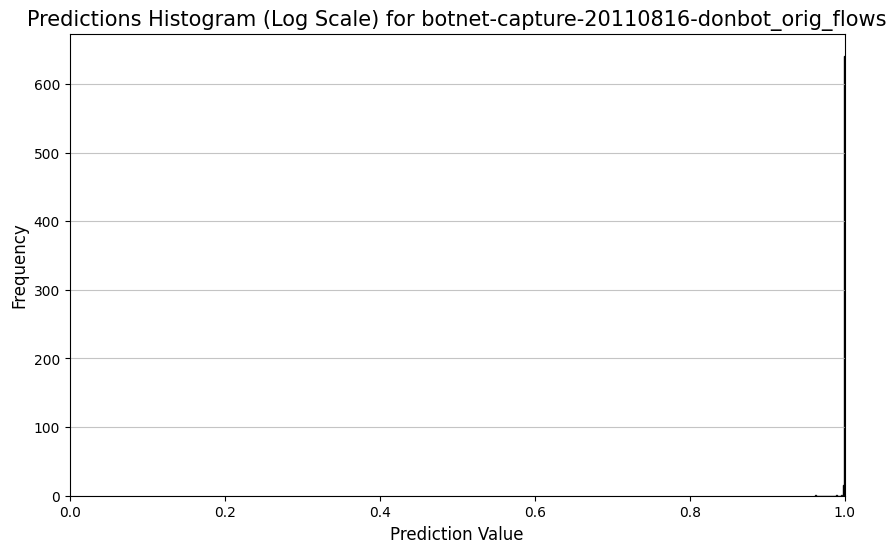

Testing botnet-capture-20110816-qvod_regressor:
Accuracy: 99.77530%
Predicted distribution: 0    0.995347
dtype: float64
Number of samples: 74
Number of malicious (1) predictions: 0    74
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


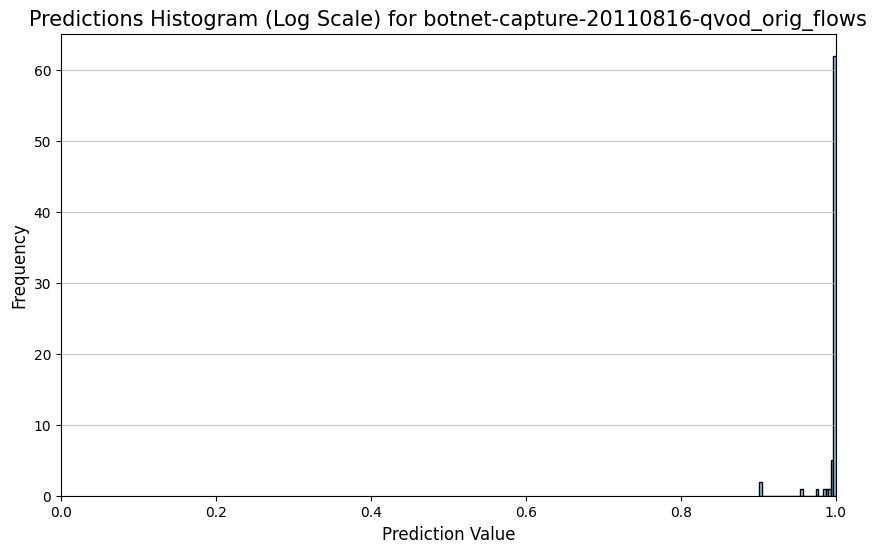

Testing botnet-capture-20110816-sogou_regressor:
Accuracy: 100.03941%
Predicted distribution: 0    0.999328
dtype: float64
Number of samples: 35
Number of malicious (1) predictions: 0    35
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


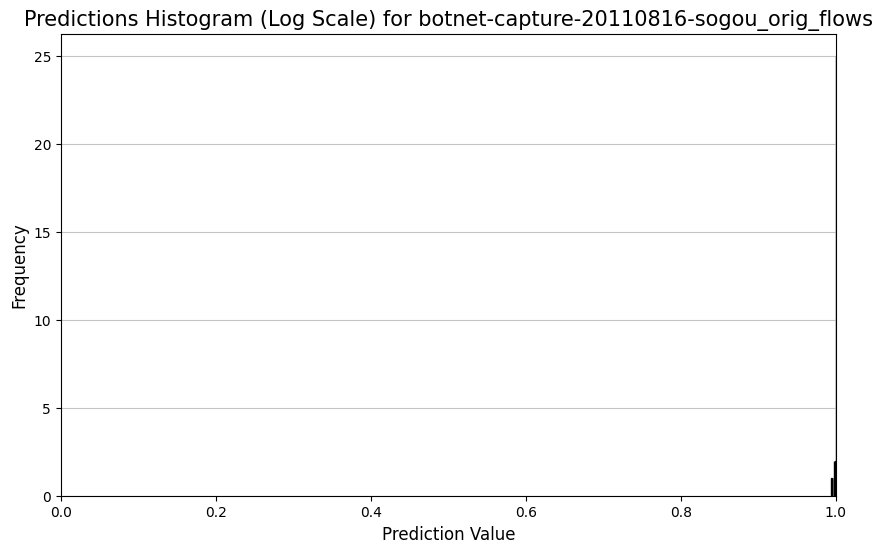

Testing botnet-capture-20110817-bot_regressor:
Accuracy: 100.00469%
Predicted distribution: 0    0.999627
dtype: float64
Number of samples: 150
Number of malicious (1) predictions: 0    150
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


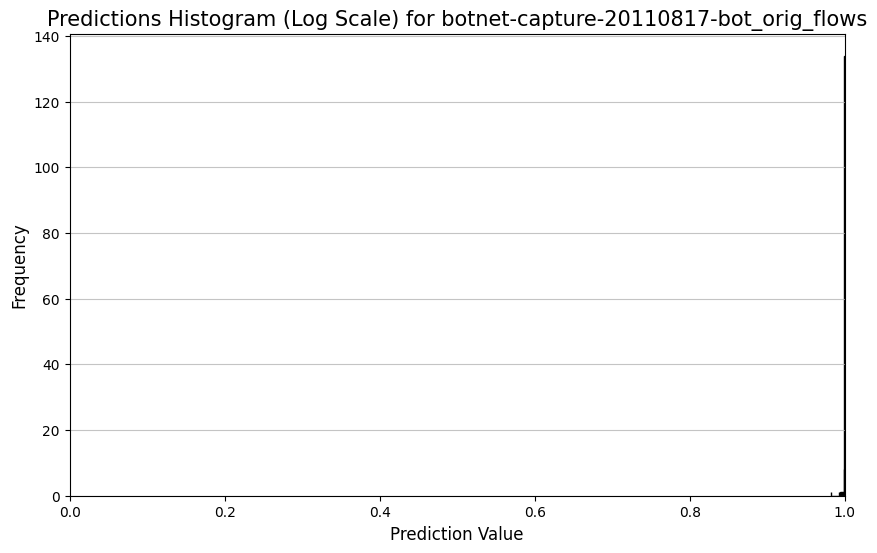

Testing botnet-capture-20110818-bot-2_regressor:
Accuracy: 100.10244%
Predicted distribution: 0    0.99977
dtype: float64
Number of samples: 252
Number of malicious (1) predictions: 0    252
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


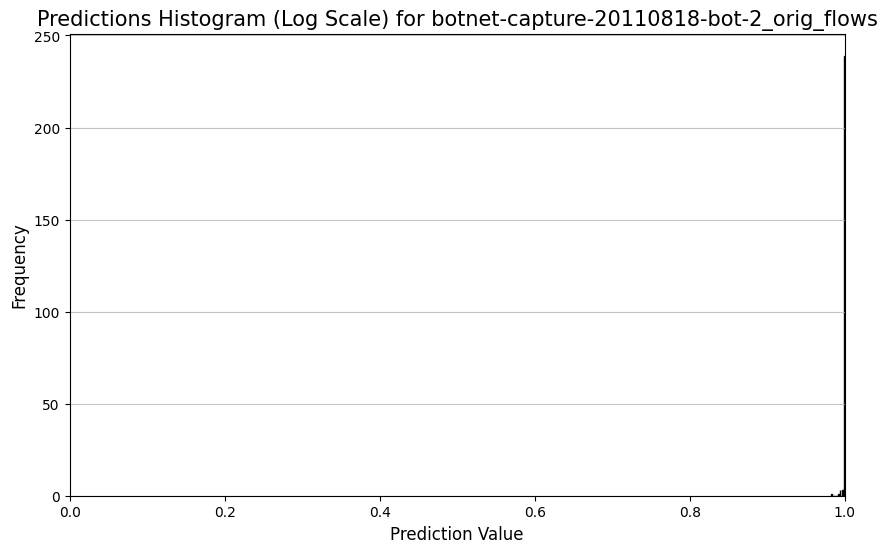

Testing botnet-capture-20110819-bot_regressor:
Accuracy: 99.09364%
Predicted distribution: 0    0.989609
dtype: float64
Number of samples: 62
Number of malicious (1) predictions: 0    62
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64



/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


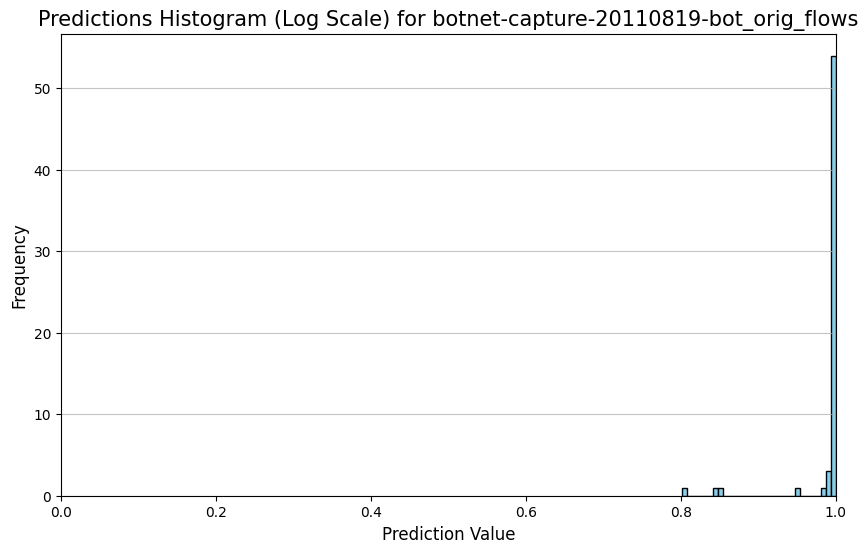

Accuracy final mean: 0.9909363745683942


In [42]:
# # before PERTURBATIONS

import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor

import sys, os
sys.path.append(os.path.abspath('../'))
from src.data.cic_preprocess import *

# Directory paths
models_dir = "../models"
data_dir = "../data/processed"

# Loading models
models = {file.split('_model.cbm')[0]: CatBoostRegressor().load_model(os.path.join(models_dir, file))
          for file in os.listdir(models_dir) if file.endswith('.cbm')}

accuracies = []

for capture in captures:

    # Testing models
    accuracies = []
    for model_name, model in models.items():
        if capture in model_name and "regressor" in model_name:
            # File name of the test data corresponds to the model name
            test_file_name = f"{capture}_orig_flows.csv"
            test_file_path = os.path.join(data_dir, test_file_name)
            
            # Loading test data
            X_test = preprocess_traffic(test_file_path)
            y_test = np.ones(X_test.shape[0])  # Assuming all samples are malicious, so y_test should be all ones
            
            # Model prediction
            predictions = model.predict(X_test)
            
            # Calculating accuracy
            accuracy = np.mean(predictions)
            accuracies.append(accuracy)
            
            predictions = pd.DataFrame(predictions).clip(lower=0, upper =1)
            
            
            # Detailed logging
            print(f"Testing {model_name}:")
            print(f"Accuracy: {accuracy:.5%}")
            print(f"Predicted distribution: {predictions.mean()}")
            print(f"Number of samples: {len(predictions)}")
            print(f"Number of malicious (1) predictions: {np.sum(predictions > 0.5)}")
            print(f"Number of benign (0) predictions: {np.sum(predictions <= 0.5)}\n")

            # Average accuracy
            #mean_accuracy = np.mean(accuracies)
            #print(f"\nAverage accuracy across all test cases: {mean_accuracy:.5%}")
            
           
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 6))
            plt.hist(predictions, bins=30, color='skyblue', edgecolor='black', log=False)
            plt.title(f'Predictions Histogram (Log Scale) for {capture}_orig_flows', fontsize=15)
            plt.xlabel('Prediction Value', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.grid(axis='y', alpha=0.75)
            plt.xlim(0, 1.0)

            plt.show()


print(f"Accuracy final mean: {np.mean(accuracies)}")



Testing botnet-capture-20110811-neris_regressor:
Accuracy: 94.76481%
Predicted distribution: 0    0.947648
dtype: float64
Number of samples: 616
Number of malicious (1) predictions: 0    608
dtype: int64
Number of benign (0) predictions: 0    8
dtype: int64


Average accuracy across all test cases: 94.76481%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


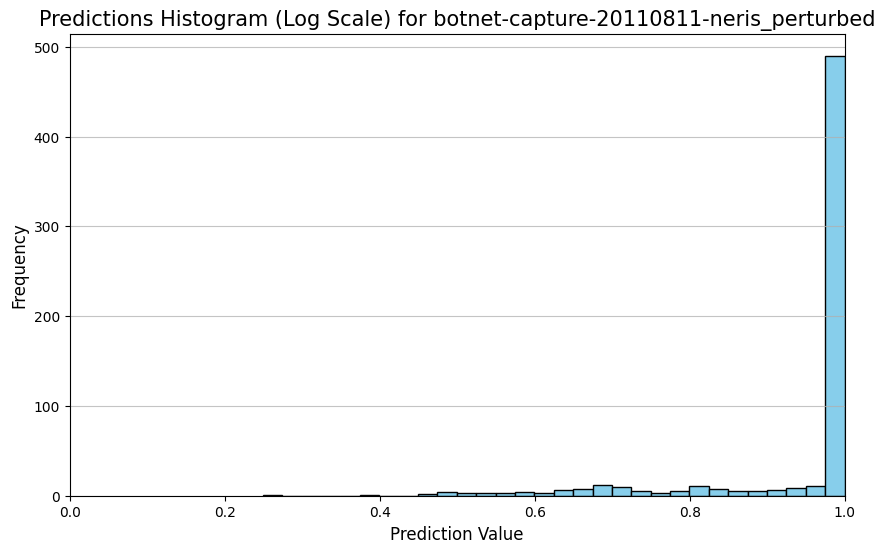

Testing botnet-capture-20110812-rbot_regressor:
Accuracy: 98.56731%
Predicted distribution: 0    0.985673
dtype: float64
Number of samples: 454
Number of malicious (1) predictions: 0    454
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 98.56731%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


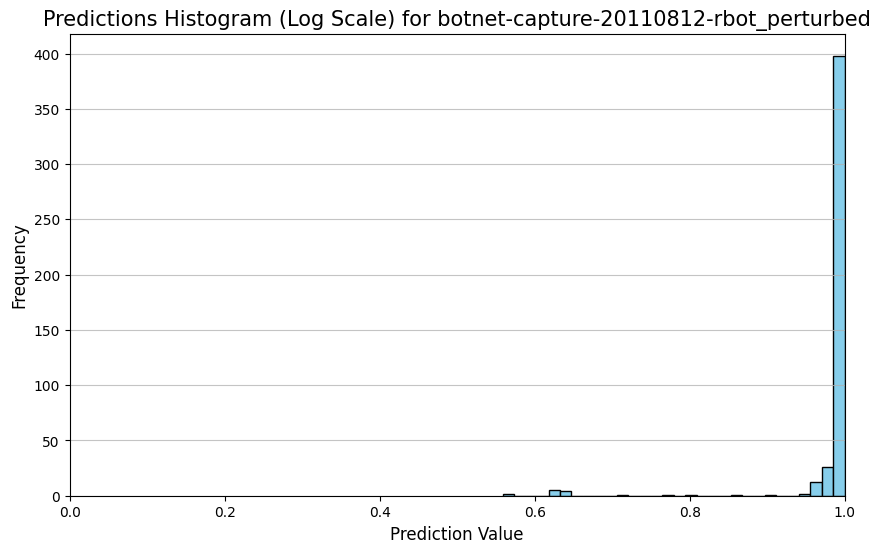

Testing botnet-capture-20110815-fast-flux-2_regressor:
Accuracy: 88.06261%
Predicted distribution: 0    0.880626
dtype: float64
Number of samples: 426
Number of malicious (1) predictions: 0    426
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 88.06261%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


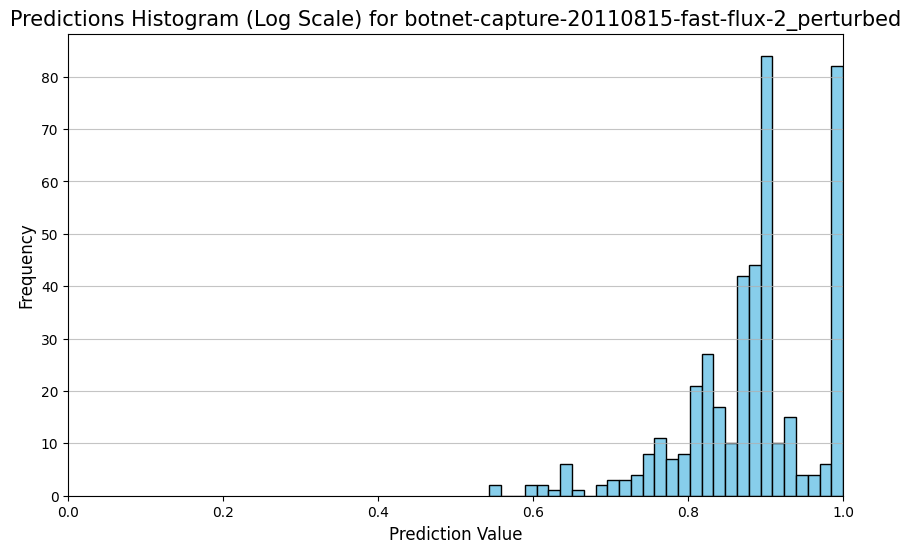

Testing botnet-capture-20110815-fast-flux-2_regressor:
Accuracy: 93.36409%
Predicted distribution: 0    0.933641
dtype: float64
Number of samples: 168
Number of malicious (1) predictions: 0    168
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 93.36409%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


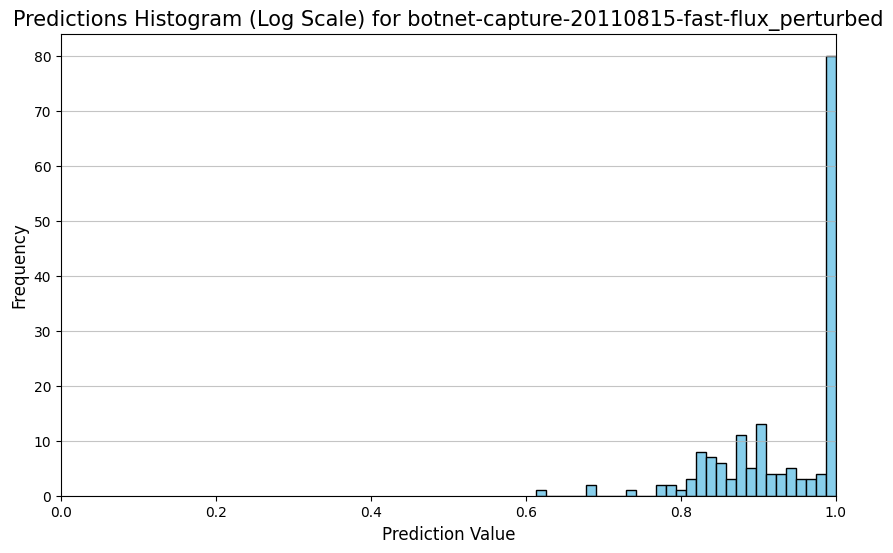

Testing botnet-capture-20110815-fast-flux_regressor:
Accuracy: 92.11974%
Predicted distribution: 0    0.921197
dtype: float64
Number of samples: 168
Number of malicious (1) predictions: 0    167
dtype: int64
Number of benign (0) predictions: 0    1
dtype: int64


Average accuracy across all test cases: 92.74191%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


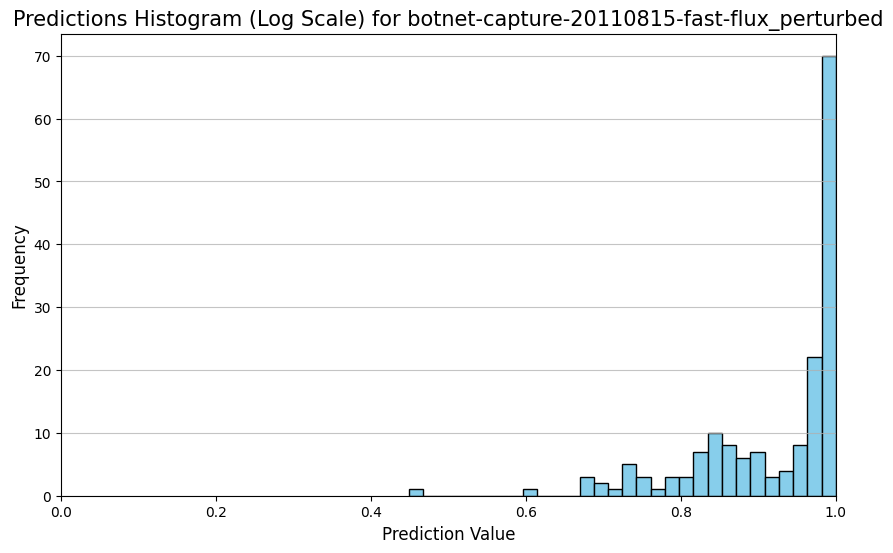

Testing botnet-capture-20110815-rbot-dos_regressor:
Accuracy: 76.68164%
Predicted distribution: 0    0.766816
dtype: float64
Number of samples: 86
Number of malicious (1) predictions: 0    81
dtype: int64
Number of benign (0) predictions: 0    5
dtype: int64


Average accuracy across all test cases: 76.68164%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


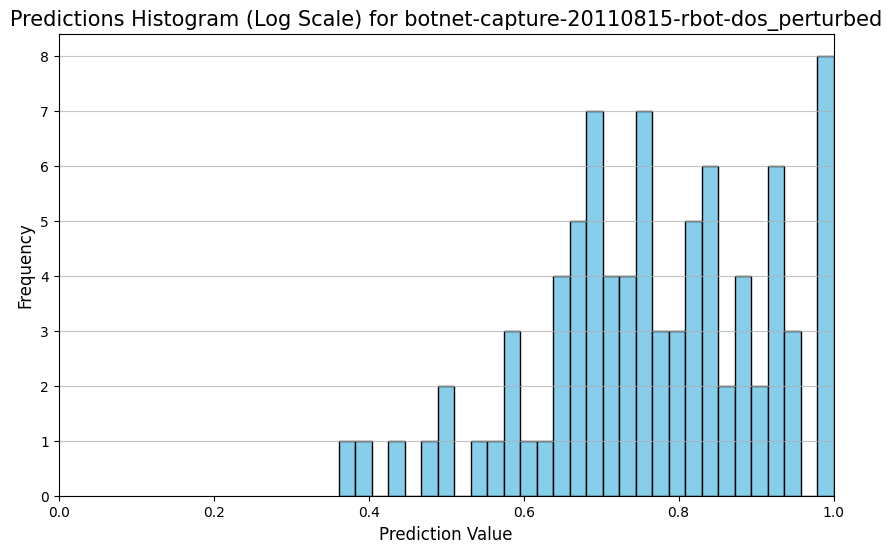

Testing botnet-capture-20110816-donbot_regressor:
Accuracy: 95.13849%
Predicted distribution: 0    0.951385
dtype: float64
Number of samples: 660
Number of malicious (1) predictions: 0    659
dtype: int64
Number of benign (0) predictions: 0    1
dtype: int64


Average accuracy across all test cases: 95.13849%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


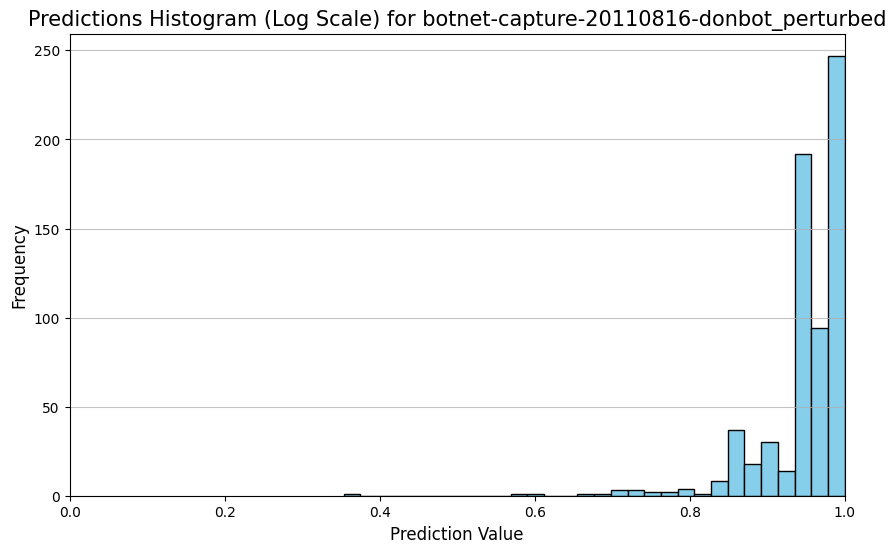

Testing botnet-capture-20110816-qvod_regressor:
Accuracy: 90.80636%
Predicted distribution: 0    0.908064
dtype: float64
Number of samples: 118
Number of malicious (1) predictions: 0    115
dtype: int64
Number of benign (0) predictions: 0    3
dtype: int64


Average accuracy across all test cases: 90.80636%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


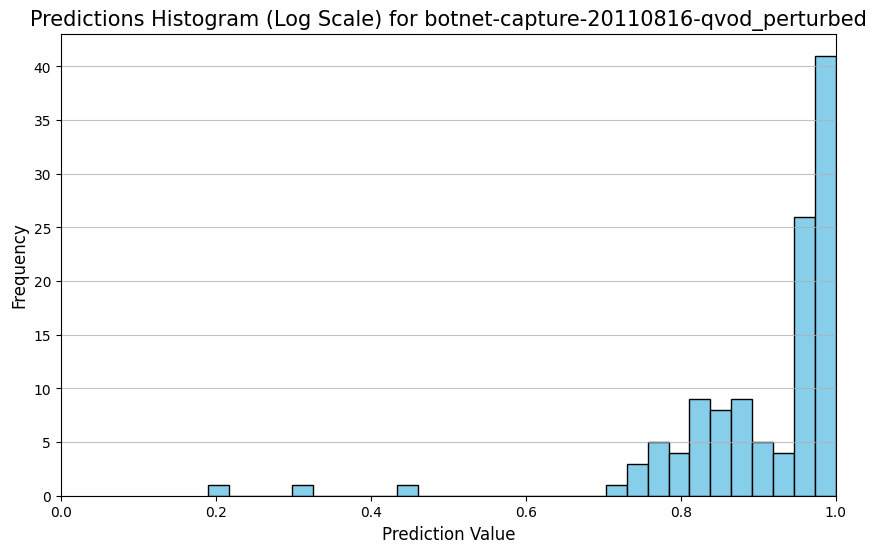

Testing botnet-capture-20110816-sogou_regressor:
Accuracy: 96.55927%
Predicted distribution: 0    0.965593
dtype: float64
Number of samples: 35
Number of malicious (1) predictions: 0    35
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 96.55927%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


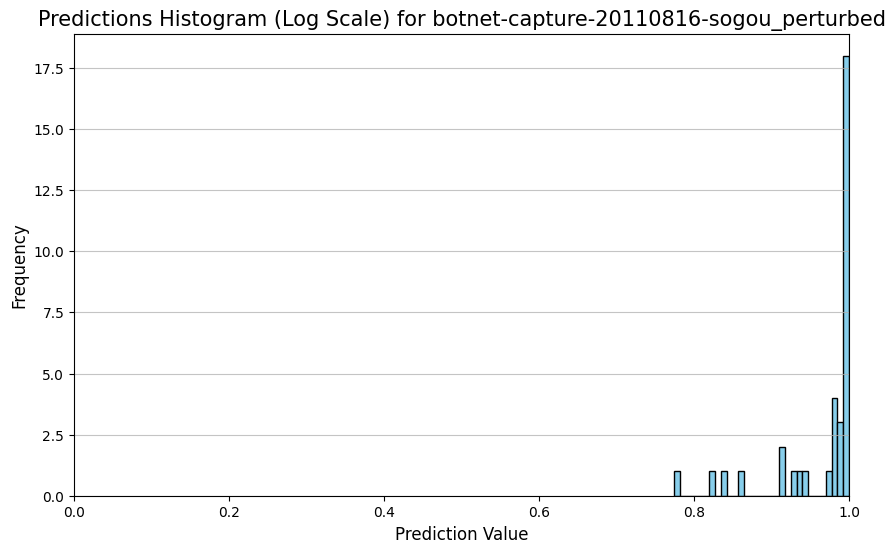

Testing botnet-capture-20110817-bot_regressor:
Accuracy: 98.02185%
Predicted distribution: 0    0.980219
dtype: float64
Number of samples: 171
Number of malicious (1) predictions: 0    171
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 98.02185%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


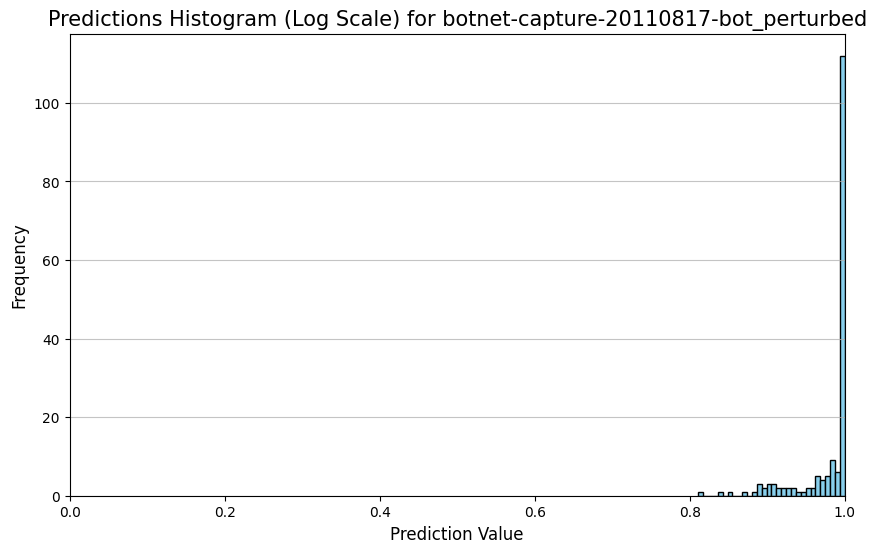

Testing botnet-capture-20110818-bot-2_regressor:
Accuracy: 81.19625%
Predicted distribution: 0    0.811962
dtype: float64
Number of samples: 252
Number of malicious (1) predictions: 0    252
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 81.19625%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


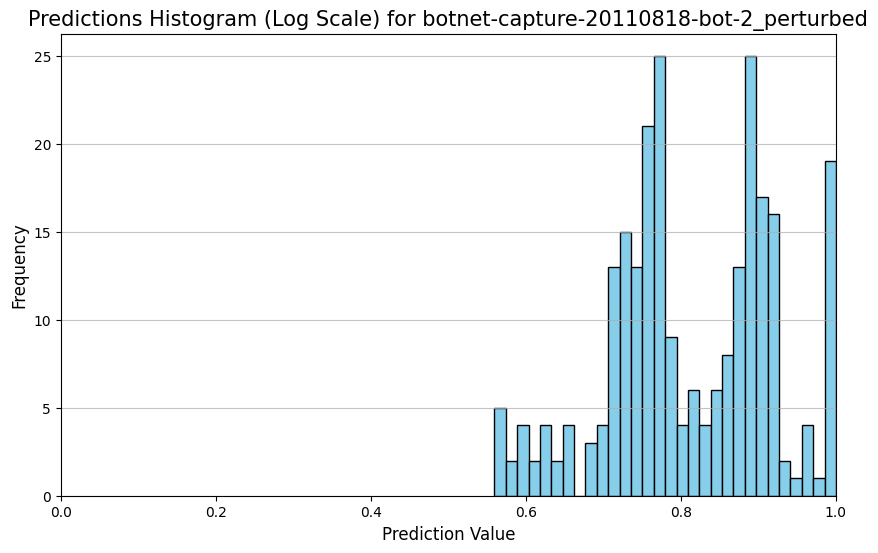

Testing botnet-capture-20110819-bot_regressor:
Accuracy: 93.75615%
Predicted distribution: 0    0.937561
dtype: float64
Number of samples: 65
Number of malicious (1) predictions: 0    64
dtype: int64
Number of benign (0) predictions: 0    1
dtype: int64


Average accuracy across all test cases: 93.75615%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


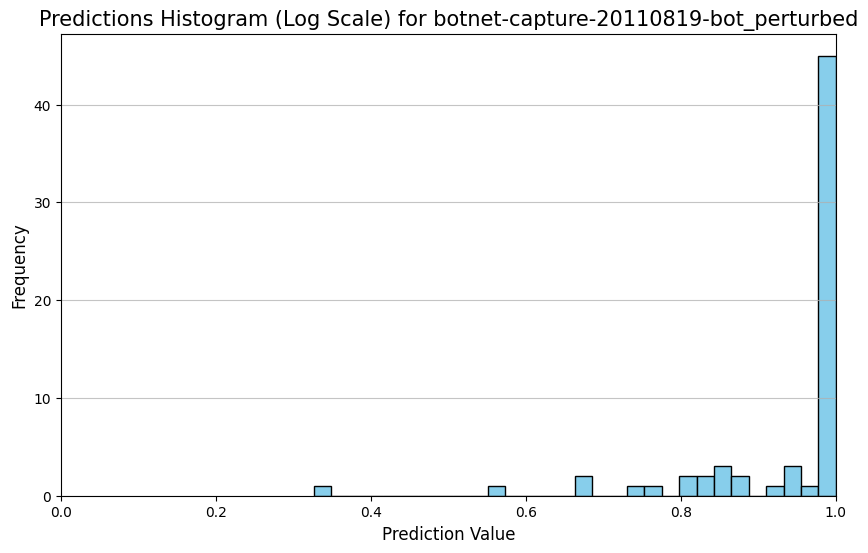

Accuracy final mean: 0.937561458894474


In [41]:
# # after fitness PERTURBATIONS

import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor

import sys, os
sys.path.append(os.path.abspath('../'))
from src.data.cic_preprocess import *

# Directory paths
models_dir = "../models"
data_dir = "../data/processed"

# Loading models
models = {file.split('_model.cbm')[0]: CatBoostRegressor().load_model(os.path.join(models_dir, file))
          for file in os.listdir(models_dir) if file.endswith('.cbm')}

accuracies = []

for capture in captures:

    # Testing models
    accuracies = []
    for model_name, model in models.items():
        if capture in model_name and "regressor" in model_name:
            # File name of the test data corresponds to the model name
            test_file_name = f"{capture}_perturbed_flows.csv"
            test_file_path = os.path.join(data_dir, test_file_name)
            
            # Loading test data
            X_test = preprocess_traffic(test_file_path)
            y_test = np.ones(X_test.shape[0])  # Assuming all samples are malicious, so y_test should be all ones
            
            # Model prediction
            predictions = model.predict(X_test)
            
            # Calculating accuracy
            #accuracies.append(predictions)
            
            predictions = pd.DataFrame(predictions).clip(lower=0, upper =1)
            accuracy = np.mean(predictions)

            accuracies.append(accuracy)
            
            
            # Detailed logging
            print(f"Testing {model_name}:")
            print(f"Accuracy: {accuracy:.5%}")
            print(f"Predicted distribution: {predictions.mean()}")
            print(f"Number of samples: {len(predictions)}")
            print(f"Number of malicious (1) predictions: {np.sum(predictions > 0.5)}")
            print(f"Number of benign (0) predictions: {np.sum(predictions <= 0.5)}\n")

            # Average accuracy
            mean_accuracy = np.mean(accuracies)
            print(f"\nAverage accuracy across all test cases: {mean_accuracy:.5%}")
            
           
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 6))
            plt.hist(predictions, bins=30, color='skyblue', edgecolor='black', log=False)
            plt.title(f'Predictions Histogram (Log Scale) for {capture}_perturbed', fontsize=15)
            plt.xlabel('Prediction Value', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.grid(axis='y', alpha=0.75)
            plt.xlim(0, 1.0)

            plt.show()


print(f"Accuracy final mean: {np.mean(accuracies)}")



Testing botnet-capture-20110811-neris_regressor:
Accuracy: 86.87019%
Predicted distribution: 0    0.868702
dtype: float64
Number of samples: 655
Number of malicious (1) predictions: 0    613
dtype: int64
Number of benign (0) predictions: 0    42
dtype: int64


Average accuracy across all test cases: 86.87019%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


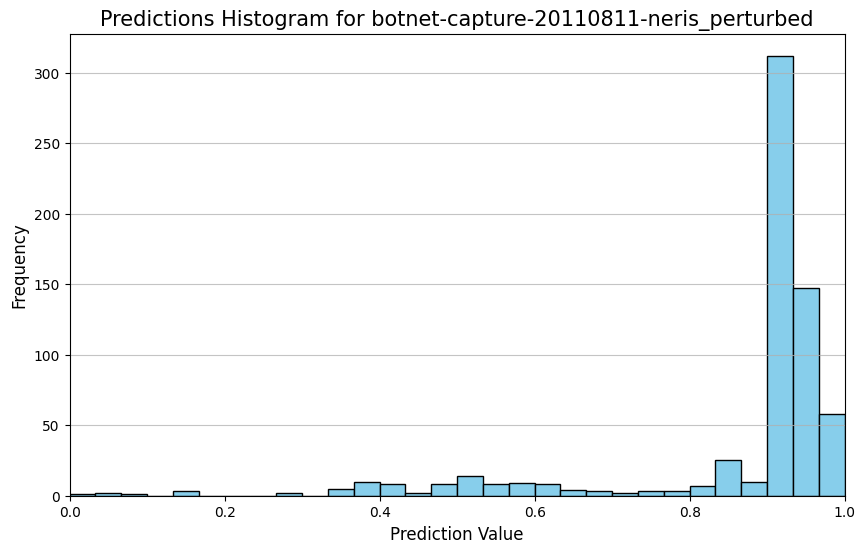

Testing botnet-capture-20110812-rbot_regressor:
Accuracy: 93.47086%
Predicted distribution: 0    0.934709
dtype: float64
Number of samples: 493
Number of malicious (1) predictions: 0    468
dtype: int64
Number of benign (0) predictions: 0    25
dtype: int64


Average accuracy across all test cases: 93.47086%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


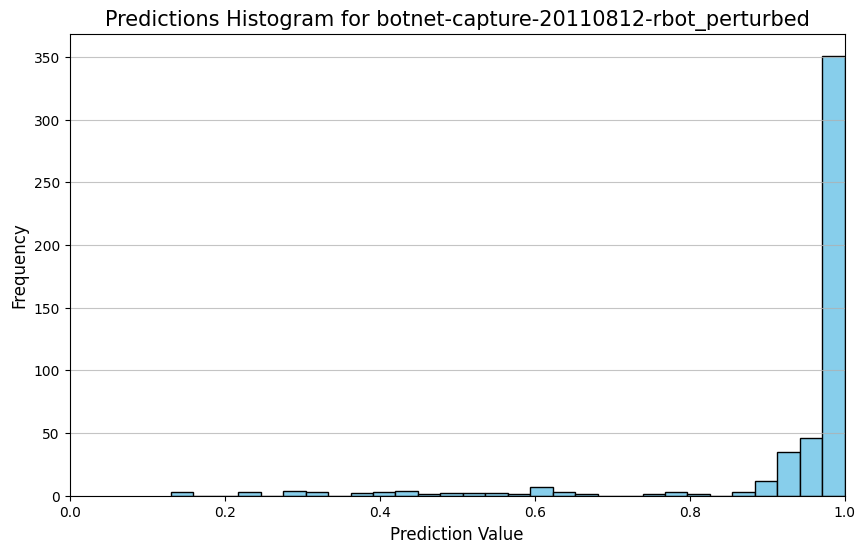

Testing botnet-capture-20110815-fast-flux-2_regressor:
Accuracy: 75.33055%
Predicted distribution: 0    0.753306
dtype: float64
Number of samples: 370
Number of malicious (1) predictions: 0    356
dtype: int64
Number of benign (0) predictions: 0    14
dtype: int64


Average accuracy across all test cases: 75.33055%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


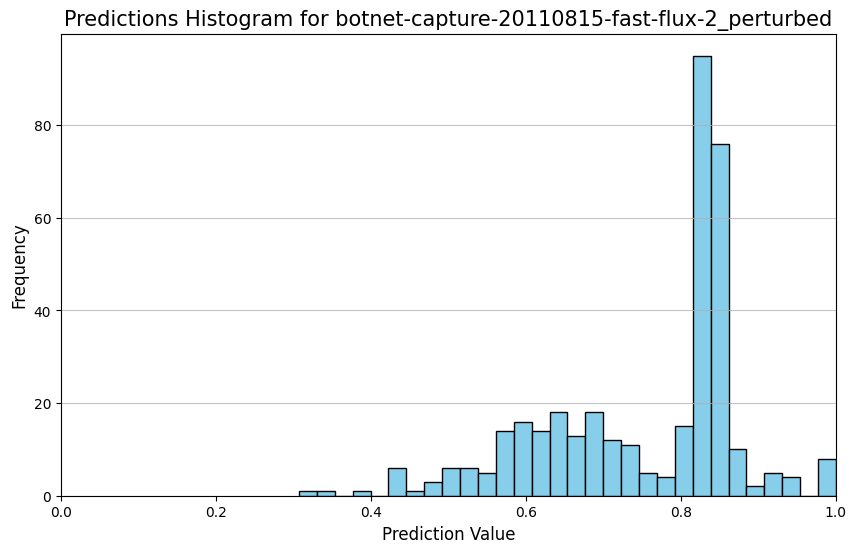

Testing botnet-capture-20110815-fast-flux-2_regressor:
Accuracy: 86.48855%
Predicted distribution: 0    0.864885
dtype: float64
Number of samples: 141
Number of malicious (1) predictions: 0    140
dtype: int64
Number of benign (0) predictions: 0    1
dtype: int64


Average accuracy across all test cases: 86.48855%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


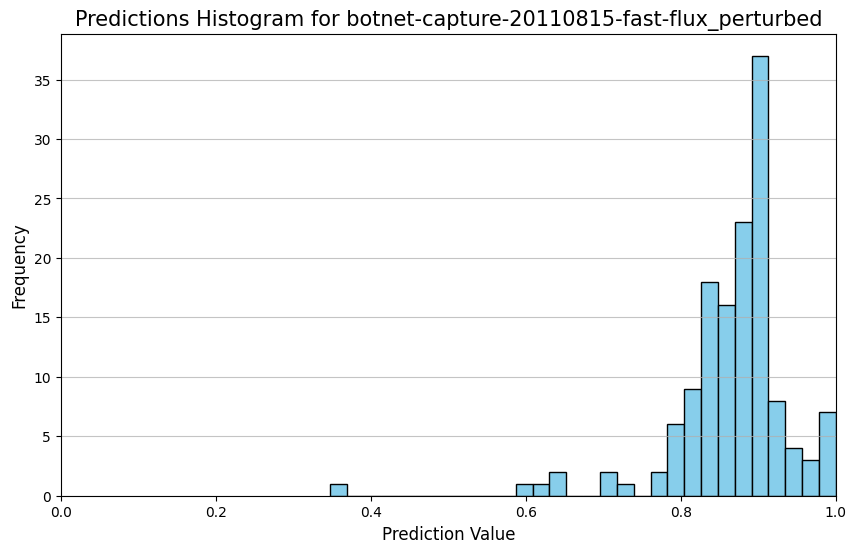

Testing botnet-capture-20110815-fast-flux_regressor:
Accuracy: 81.80432%
Predicted distribution: 0    0.818043
dtype: float64
Number of samples: 141
Number of malicious (1) predictions: 0    139
dtype: int64
Number of benign (0) predictions: 0    2
dtype: int64


Average accuracy across all test cases: 84.14643%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


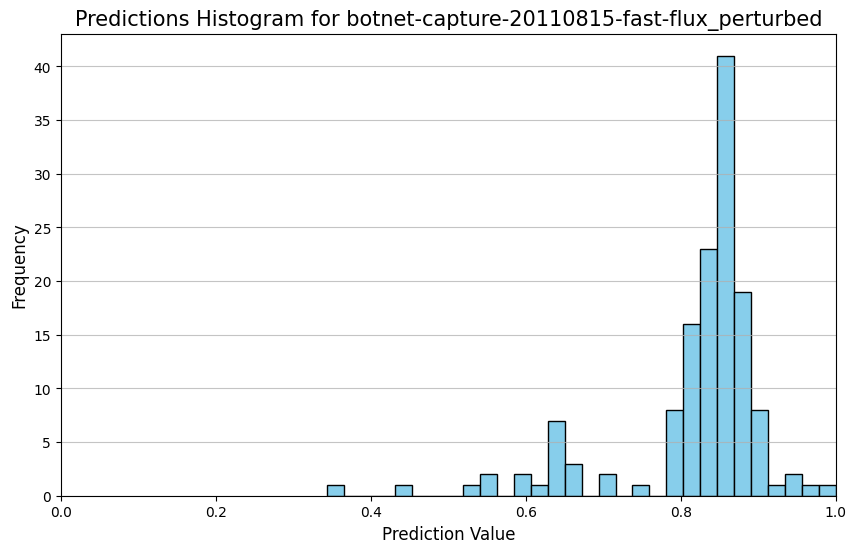

Testing botnet-capture-20110815-rbot-dos_regressor:
Accuracy: 60.92909%
Predicted distribution: 0    0.609291
dtype: float64
Number of samples: 92
Number of malicious (1) predictions: 0    48
dtype: int64
Number of benign (0) predictions: 0    44
dtype: int64


Average accuracy across all test cases: 60.92909%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


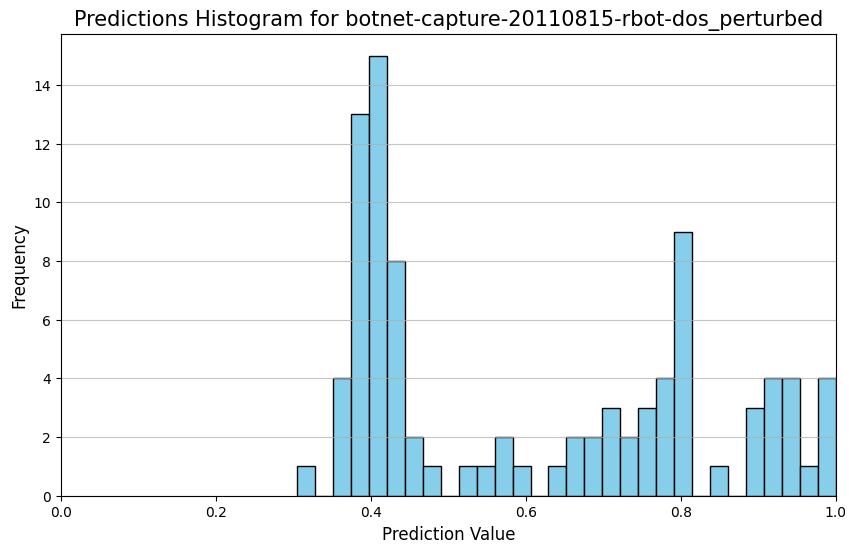

Testing botnet-capture-20110816-donbot_regressor:
Accuracy: 93.56421%
Predicted distribution: 0    0.935642
dtype: float64
Number of samples: 660
Number of malicious (1) predictions: 0    653
dtype: int64
Number of benign (0) predictions: 0    7
dtype: int64


Average accuracy across all test cases: 93.56421%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


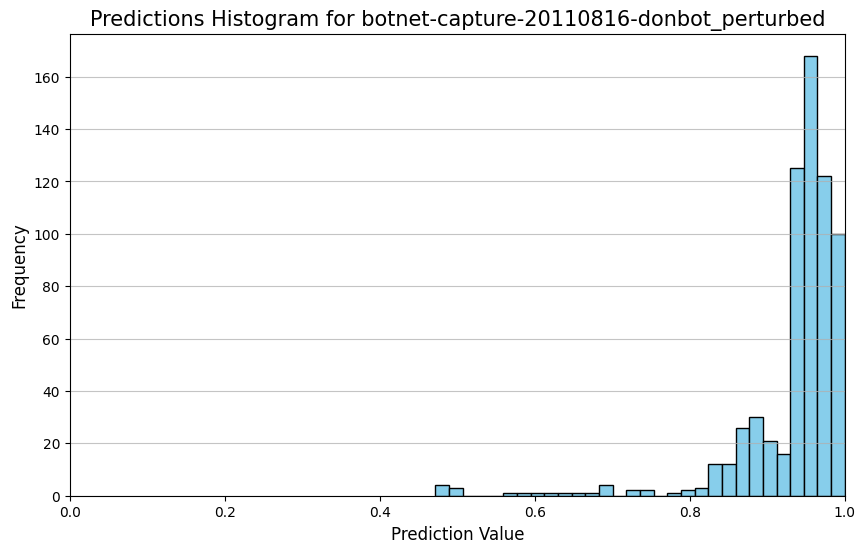

Testing botnet-capture-20110816-qvod_regressor:
Accuracy: 79.56979%
Predicted distribution: 0    0.795698
dtype: float64
Number of samples: 86
Number of malicious (1) predictions: 0    84
dtype: int64
Number of benign (0) predictions: 0    2
dtype: int64


Average accuracy across all test cases: 79.56979%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


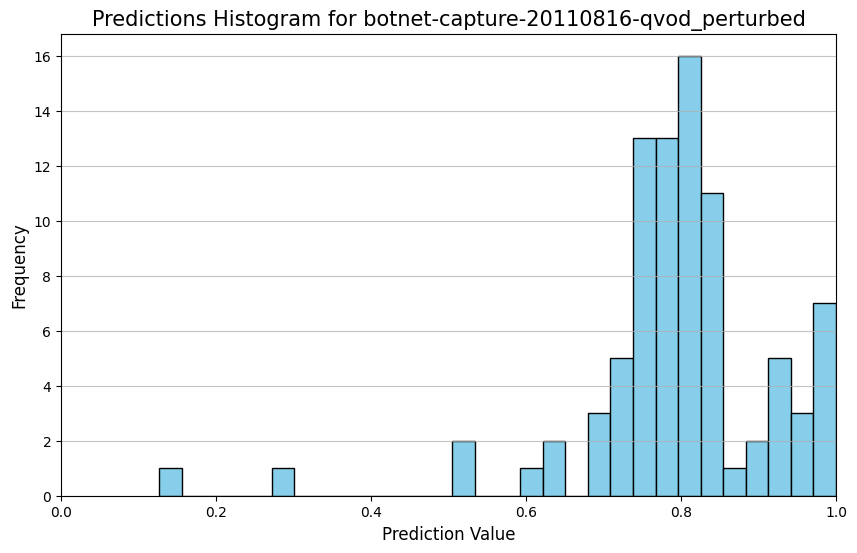

Testing botnet-capture-20110816-sogou_regressor:
Accuracy: 93.18118%
Predicted distribution: 0    0.931812
dtype: float64
Number of samples: 37
Number of malicious (1) predictions: 0    37
dtype: int64
Number of benign (0) predictions: 0    0
dtype: int64


Average accuracy across all test cases: 93.18118%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


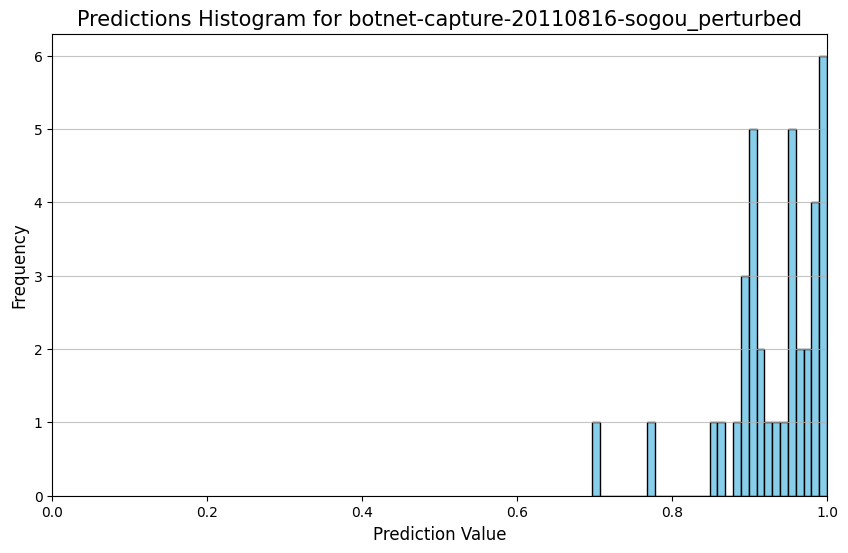

Testing botnet-capture-20110817-bot_regressor:
Accuracy: 86.85960%
Predicted distribution: 0    0.868596
dtype: float64
Number of samples: 178
Number of malicious (1) predictions: 0    172
dtype: int64
Number of benign (0) predictions: 0    6
dtype: int64


Average accuracy across all test cases: 86.85960%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


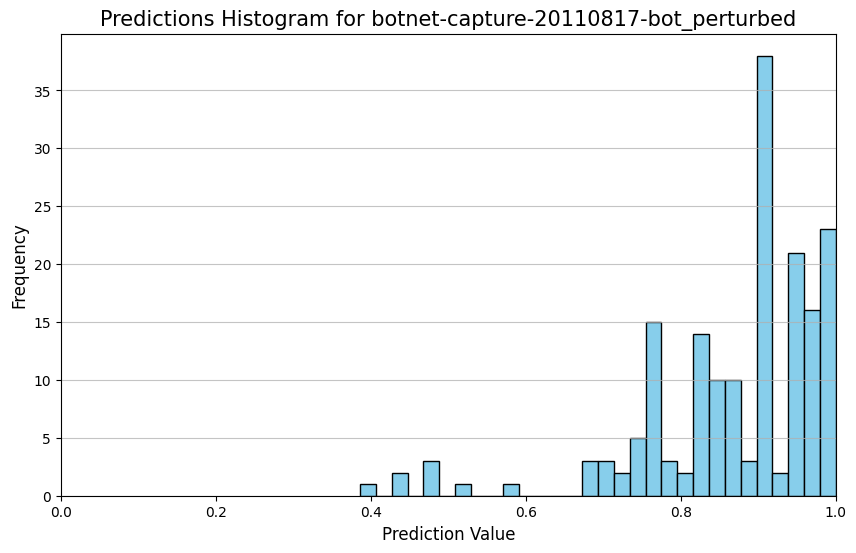

Testing botnet-capture-20110818-bot-2_regressor:
Accuracy: 74.31210%
Predicted distribution: 0    0.743121
dtype: float64
Number of samples: 259
Number of malicious (1) predictions: 0    257
dtype: int64
Number of benign (0) predictions: 0    2
dtype: int64


Average accuracy across all test cases: 74.31210%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


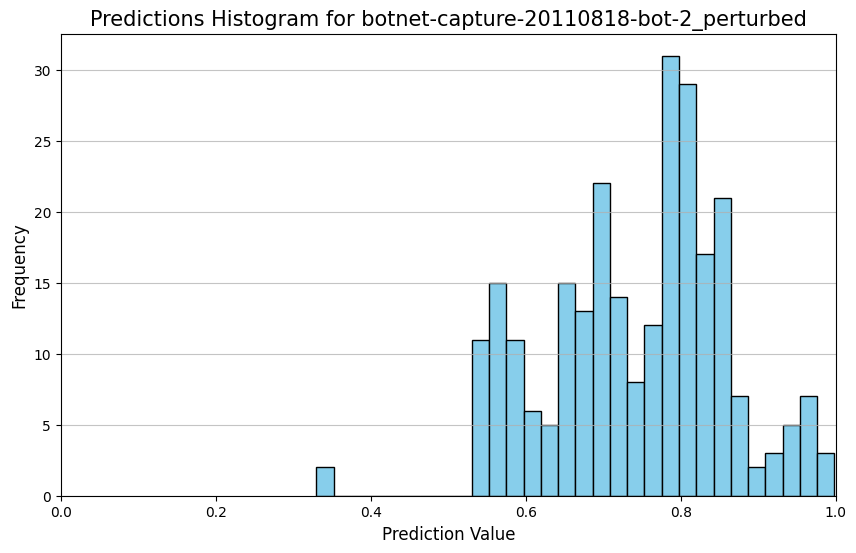

Testing botnet-capture-20110819-bot_regressor:
Accuracy: 82.46462%
Predicted distribution: 0    0.824646
dtype: float64
Number of samples: 63
Number of malicious (1) predictions: 0    59
dtype: int64
Number of benign (0) predictions: 0    4
dtype: int64


Average accuracy across all test cases: 82.46462%


/home/user/miniconda3/envs/cyberaml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


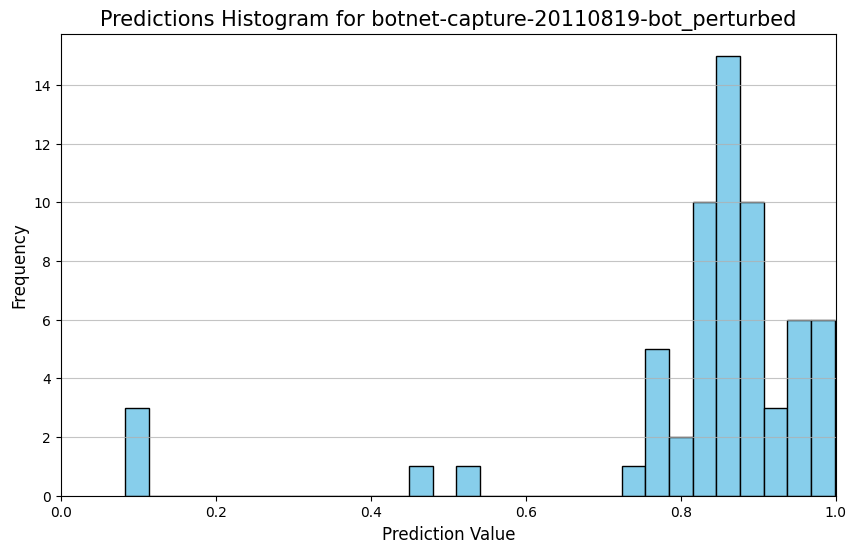

Accuracy final mean: 0.8246462296494654


In [40]:
# # after target PERTURBATIONS

import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor

import sys, os
sys.path.append(os.path.abspath('../'))
from src.data.cic_preprocess import *

# Directory paths
models_dir = "../models"
data_dir = "../data/processed"

# Loading models
models = {file.split('_model.cbm')[0]: CatBoostRegressor().load_model(os.path.join(models_dir, file))
          for file in os.listdir(models_dir) if file.endswith('.cbm')}

accuracies = []

for capture in captures:

    # Testing models
    accuracies = []
    for model_name, model in models.items():
        if capture in model_name and "regressor" in model_name:
            # File name of the test data corresponds to the model name
            test_file_name = f"{capture}_perturbed_target_flows.csv"
            test_file_path = os.path.join(data_dir, test_file_name)
            
            # Loading test data
            X_test = preprocess_traffic(test_file_path)
            y_test = np.ones(X_test.shape[0])  # Assuming all samples are malicious, so y_test should be all ones
            
            # Model prediction
            predictions = model.predict(X_test)
            
            predictions = pd.DataFrame(predictions).clip(lower=0, upper =1)

            accuracy = np.mean(predictions)
            accuracies.append(accuracy)
            
            # Detailed logging
            print(f"Testing {model_name}:")
            print(f"Accuracy: {accuracy:.5%}")
            print(f"Predicted distribution: {predictions.mean()}")
            print(f"Number of samples: {len(predictions)}")
            print(f"Number of malicious (1) predictions: {np.sum(predictions > 0.5)}")
            print(f"Number of benign (0) predictions: {np.sum(predictions <= 0.5)}\n")

            # Average accuracy
            mean_accuracy = np.mean(accuracies)
            print(f"\nAverage accuracy across all test cases: {mean_accuracy:.5%}")
            
           
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 6))
            plt.hist(predictions, bins=30, color='skyblue', edgecolor='black', log=False)
            plt.title(f'Predictions Histogram for {capture}_perturbed', fontsize=15)
            plt.xlabel('Prediction Value', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.grid(axis='y', alpha=0.75)
            plt.xlim(0, 1.0)

            plt.show()

print(f"Accuracy final mean: {np.mean(accuracies)}")


In [ ]:
# fitness from 

In [ ]:
# TODO: wizualizacja do pokazania spadku po funkcji fitness []

In [ ]:
# TODO: sprawdzenie wyników bez flow o długości 0 [] (?)